In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2025-05-15 13:01:45--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-05-15 13:01:45--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  10.0MB/s    in 20s     

2025-05-15 13:02:04 (12.1 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [2]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import timm
import pandas as pd

# Step 2: Fix val/ structure based on val_annotations.txt
val_dir = '/kaggle/working/tiny-imagenet-200/val'
val_images_dir = os.path.join(val_dir, 'images')
annotations_file = os.path.join(val_dir, 'val_annotations.txt')

# Parse val_annotations.txt
val_df = pd.read_csv(annotations_file, sep='\t', header=None)
val_df.columns = ['filename', 'class', 'x1', 'y1', 'x2', 'y2']

# Create subfolders by class & move images
for _, row in val_df.iterrows():
    class_folder = os.path.join(val_dir, 'images', row['class'])
    os.makedirs(class_folder, exist_ok=True)
    src = os.path.join(val_images_dir, row['filename'])
    dst = os.path.join(class_folder, row['filename'])
    if os.path.exists(src):
        shutil.move(src, dst)

# Remove unused files
for f in os.listdir(val_images_dir):
    path = os.path.join(val_images_dir, f)
    if os.path.isfile(path):
        os.remove(path)

# Step 3: Transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(96),
    transforms.ToTensor(),
    transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)),
])

transform_val = transforms.Compose([
    transforms.Resize(96),
    transforms.CenterCrop(96),
    transforms.ToTensor(),
    transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)),
])

# Step 4: Data loaders
train_dir = '/kaggle/working/tiny-imagenet-200/train'
val_dir_reorg = '/kaggle/working/tiny-imagenet-200/val/images'

train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir_reorg, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# Step 5: Load pretrained MobileViT-XXS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('mobilevit_xxs', pretrained=True, num_classes=200)
model.to(device)

# Step 6: Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Step 7: Training loop
best_acc = 0.0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(30):
    model.train()
    total_loss = 0.0
    correct = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)  # sum of loss over batch
        correct += (outputs.argmax(1) == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_acc = correct / len(train_dataset)
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    train_acc = correct / len(train_dataset)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            correct_val += (outputs.argmax(1) == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct_val / len(val_dataset)
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    val_acc = correct_val / len(val_dataset)
    print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        torch.save(model.state_dict(), 'best_mobilevit_xxs.pth')
        print(f"✅ Saved new best model with Val Acc: {val_acc:.4f}")
        best_acc = val_acc

    scheduler.step()

for i in range(len(train_losses)):
    print(f"Epoch {i+1:02}: "
          f"Train Loss = {train_losses[i]:.4f}, Acc = {train_accuracies[i]*100:.2f}% | "
          f"Val Loss = {val_losses[i]:.4f}, Acc = {val_accuracies[i]*100:.2f}%")

model.safetensors:   0%|          | 0.00/5.14M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 1563/1563 [01:18<00:00, 19.94it/s]

Epoch 1, Train Loss: 4.1885, Acc: 0.1663


Val Loss: 3.0576, Val Acc: 0.3193
✅ Saved new best model with Val Acc: 0.3193


Epoch 2: 100%|██████████| 1563/1563 [01:21<00:00, 19.09it/s]


Epoch 2, Train Loss: 3.1294, Acc: 0.3068
Val Loss: 2.4221, Val Acc: 0.4348
✅ Saved new best model with Val Acc: 0.4348


Epoch 3: 100%|██████████| 1563/1563 [01:19<00:00, 19.75it/s]

Epoch 3, Train Loss: 2.7229, Acc: 0.3745


Val Loss: 2.0836, Val Acc: 0.4970
✅ Saved new best model with Val Acc: 0.4970


Epoch 4: 100%|██████████| 1563/1563 [01:19<00:00, 19.60it/s]

Epoch 4, Train Loss: 2.5132, Acc: 0.4116


Val Loss: 1.9218, Val Acc: 0.5279
✅ Saved new best model with Val Acc: 0.5279


Epoch 5: 100%|██████████| 1563/1563 [01:19<00:00, 19.76it/s]


Epoch 5, Train Loss: 2.3893, Acc: 0.4353
Val Loss: 1.8260, Val Acc: 0.5416
✅ Saved new best model with Val Acc: 0.5416


Epoch 6: 100%|██████████| 1563/1563 [01:17<00:00, 20.07it/s]

Epoch 6, Train Loss: 2.3107, Acc: 0.4505


Val Loss: 1.7660, Val Acc: 0.5566
✅ Saved new best model with Val Acc: 0.5566


Epoch 7: 100%|██████████| 1563/1563 [01:18<00:00, 19.90it/s]

Epoch 7, Train Loss: 2.2491, Acc: 0.4615


Val Loss: 1.7413, Val Acc: 0.5620
✅ Saved new best model with Val Acc: 0.5620


Epoch 8: 100%|██████████| 1563/1563 [01:17<00:00, 20.15it/s]

Epoch 8, Train Loss: 2.2147, Acc: 0.4694


Val Loss: 1.7139, Val Acc: 0.5690
✅ Saved new best model with Val Acc: 0.5690


Epoch 9: 100%|██████████| 1563/1563 [01:19<00:00, 19.69it/s]

Epoch 9, Train Loss: 2.1987, Acc: 0.4734


Val Loss: 1.6981, Val Acc: 0.5720
✅ Saved new best model with Val Acc: 0.5720


Epoch 10: 100%|██████████| 1563/1563 [01:17<00:00, 20.09it/s]

Epoch 10, Train Loss: 2.1870, Acc: 0.4743


Val Loss: 1.6932, Val Acc: 0.5723
✅ Saved new best model with Val Acc: 0.5723


Epoch 11: 100%|██████████| 1563/1563 [01:19<00:00, 19.70it/s]

Epoch 11, Train Loss: 2.1825, Acc: 0.4758


Val Loss: 1.6924, Val Acc: 0.5727
✅ Saved new best model with Val Acc: 0.5727


Epoch 12: 100%|██████████| 1563/1563 [01:19<00:00, 19.76it/s]

Epoch 12, Train Loss: 2.1762, Acc: 0.4760


Val Loss: 1.6914, Val Acc: 0.5734
✅ Saved new best model with Val Acc: 0.5734


Epoch 13: 100%|██████████| 1563/1563 [01:18<00:00, 19.97it/s]

Epoch 13, Train Loss: 2.1759, Acc: 0.4765


Val Loss: 1.6911, Val Acc: 0.5714


Epoch 14: 100%|██████████| 1563/1563 [01:19<00:00, 19.74it/s]

Epoch 14, Train Loss: 2.1756, Acc: 0.4767


Val Loss: 1.6761, Val Acc: 0.5763
✅ Saved new best model with Val Acc: 0.5763


Epoch 15: 100%|██████████| 1563/1563 [01:20<00:00, 19.43it/s]

Epoch 15, Train Loss: 2.1622, Acc: 0.4802


Val Loss: 1.6678, Val Acc: 0.5766
✅ Saved new best model with Val Acc: 0.5766


Epoch 16: 100%|██████████| 1563/1563 [01:17<00:00, 20.18it/s]

Epoch 16, Train Loss: 2.1485, Acc: 0.4818


Val Loss: 1.6451, Val Acc: 0.5821
✅ Saved new best model with Val Acc: 0.5821


Epoch 17: 100%|██████████| 1563/1563 [01:19<00:00, 19.77it/s]

Epoch 17, Train Loss: 2.1401, Acc: 0.4844


Val Loss: 1.6379, Val Acc: 0.5830
✅ Saved new best model with Val Acc: 0.5830


Epoch 18: 100%|██████████| 1563/1563 [01:18<00:00, 19.89it/s]

Epoch 18, Train Loss: 2.1150, Acc: 0.4874


Val Loss: 1.6299, Val Acc: 0.5846
✅ Saved new best model with Val Acc: 0.5846


Epoch 19: 100%|██████████| 1563/1563 [01:19<00:00, 19.56it/s]

Epoch 19, Train Loss: 2.0898, Acc: 0.4940


Val Loss: 1.6213, Val Acc: 0.5872
✅ Saved new best model with Val Acc: 0.5872


Epoch 20: 100%|██████████| 1563/1563 [01:19<00:00, 19.58it/s]


Epoch 20, Train Loss: 2.0636, Acc: 0.4996
Val Loss: 1.5909, Val Acc: 0.5937
✅ Saved new best model with Val Acc: 0.5937


Epoch 21: 100%|██████████| 1563/1563 [01:20<00:00, 19.41it/s]

Epoch 21, Train Loss: 2.0466, Acc: 0.5023


Val Loss: 1.5829, Val Acc: 0.5943
✅ Saved new best model with Val Acc: 0.5943


Epoch 22: 100%|██████████| 1563/1563 [01:18<00:00, 19.90it/s]

Epoch 22, Train Loss: 2.0088, Acc: 0.5112


Val Loss: 1.5477, Val Acc: 0.6054
✅ Saved new best model with Val Acc: 0.6054


Epoch 23: 100%|██████████| 1563/1563 [01:19<00:00, 19.58it/s]

Epoch 23, Train Loss: 1.9833, Acc: 0.5134


Val Loss: 1.5371, Val Acc: 0.6098
✅ Saved new best model with Val Acc: 0.6098


Epoch 24: 100%|██████████| 1563/1563 [01:18<00:00, 19.92it/s]

Epoch 24, Train Loss: 1.9608, Acc: 0.5211


Val Loss: 1.5214, Val Acc: 0.6147
✅ Saved new best model with Val Acc: 0.6147


Epoch 25: 100%|██████████| 1563/1563 [01:20<00:00, 19.51it/s]


Epoch 25, Train Loss: 1.9289, Acc: 0.5284
Val Loss: 1.5100, Val Acc: 0.6173
✅ Saved new best model with Val Acc: 0.6173


Epoch 26: 100%|██████████| 1563/1563 [01:18<00:00, 19.84it/s]

Epoch 26, Train Loss: 1.9016, Acc: 0.5349


Val Loss: 1.4968, Val Acc: 0.6183
✅ Saved new best model with Val Acc: 0.6183


Epoch 27: 100%|██████████| 1563/1563 [01:19<00:00, 19.73it/s]

Epoch 27, Train Loss: 1.8721, Acc: 0.5408


Val Loss: 1.4777, Val Acc: 0.6267
✅ Saved new best model with Val Acc: 0.6267


Epoch 28: 100%|██████████| 1563/1563 [01:19<00:00, 19.61it/s]

Epoch 28, Train Loss: 1.8621, Acc: 0.5424


Val Loss: 1.4659, Val Acc: 0.6291
✅ Saved new best model with Val Acc: 0.6291


Epoch 29: 100%|██████████| 1563/1563 [01:18<00:00, 20.00it/s]


Epoch 29, Train Loss: 1.8391, Acc: 0.5484
Val Loss: 1.4603, Val Acc: 0.6300
✅ Saved new best model with Val Acc: 0.6300


Epoch 30: 100%|██████████| 1563/1563 [01:17<00:00, 20.12it/s]


Epoch 30, Train Loss: 1.8404, Acc: 0.5488
Val Loss: 1.4590, Val Acc: 0.6307
✅ Saved new best model with Val Acc: 0.6307
Epoch 01: Train Loss = 4.1885, Acc = 16.63% | Val Loss = 3.0576, Acc = 31.93%
Epoch 02: Train Loss = 3.1294, Acc = 30.68% | Val Loss = 2.4221, Acc = 43.48%
Epoch 03: Train Loss = 2.7229, Acc = 37.45% | Val Loss = 2.0836, Acc = 49.70%
Epoch 04: Train Loss = 2.5132, Acc = 41.16% | Val Loss = 1.9218, Acc = 52.79%
Epoch 05: Train Loss = 2.3893, Acc = 43.53% | Val Loss = 1.8260, Acc = 54.16%
Epoch 06: Train Loss = 2.3107, Acc = 45.05% | Val Loss = 1.7660, Acc = 55.66%
Epoch 07: Train Loss = 2.2491, Acc = 46.15% | Val Loss = 1.7413, Acc = 56.20%
Epoch 08: Train Loss = 2.2147, Acc = 46.94% | Val Loss = 1.7139, Acc = 56.90%
Epoch 09: Train Loss = 2.1987, Acc = 47.34% | Val Loss = 1.6981, Acc = 57.20%
Epoch 10: Train Loss = 2.1870, Acc = 47.43% | Val Loss = 1.6932, Acc = 57.23%
Epoch 11: Train Loss = 2.1825, Acc = 47.58% | Val Loss = 1.6924, Acc = 57.27%
Epoch 12: Train Loss =

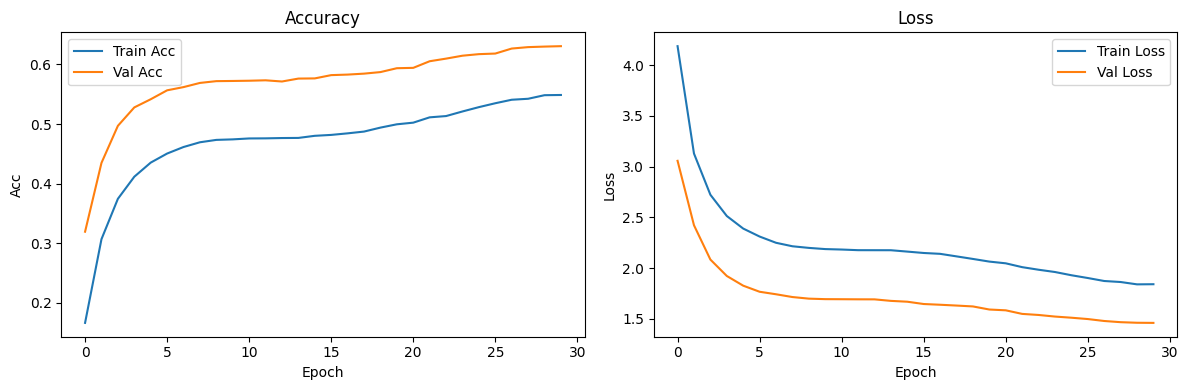

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()